In [1]:
import numpy as np
import pandas as pd
from new_SPOC import *
import old_SPOC as old_SPOC
from generate_SPOC_model import *
import matplotlib.pyplot as plt
import matlab.engine
from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output, display

%matplotlib inline

eng = matlab.engine.start_matlab()

In [6]:
generate_theta(n_nodes=5, n_clusters=2, pure_nodes_number=2, alphas=[1.5, 0.05])

array([[  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.38398856e-39],
       [  9.48971051e-01,   5.10289494e-02],
       [  1.00000000e+00,   2.09209156e-11],
       [  1.00000000e+00,   0.00000000e+00]])

In [7]:
np.arange(0, 4, 0.5)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5])

In [12]:
n_nodes = 100
rho = 0.7
n_clusters = 3
B = np.diag([0.4, 0.7, 1.])
n_repetitions = 2
pn_number = n_clusters

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number", "alpha",\
                                 "seed", "method", "matrix", "error"])

for alpha in np.arange(0.5, 4, 0.5):
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pn_number, \
                               seed=repeat, alphas=[alpha/n_clusters] * n_clusters)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        
        err, _ = find_permutation_Theta(Theta, theta_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"Geo_NMF", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"Geo_NMF", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_spa, b_spa = SPOC(A, n_clusters)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"basic_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_spa)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"basic_SPA", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_bootstrap, b_bootstrap = SPOC_bootstrap(A, n_clusters, n_repetitions=300, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"bootstrap_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_bootstrap)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pn_number,\
                "alpha":alpha, "seed":repeat, "method":"bootstrap_SPA", "matrix":"B", "error":err}, ignore_index=True)

EXP_DATA.to_csv("alpha.csv", index=None)

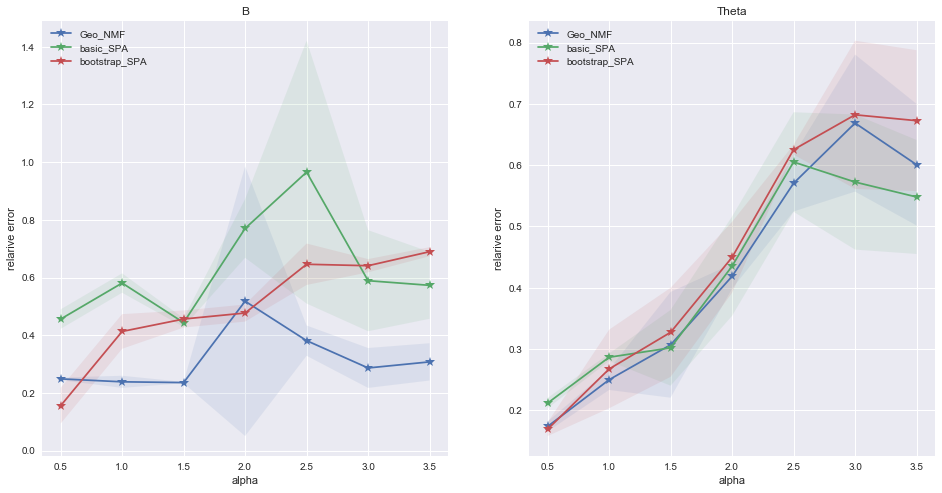

In [15]:
df = EXP_DATA.groupby(["alpha",  "method", "matrix"]).error.mean().reset_index()
std = EXP_DATA.groupby(["alpha",  "method", "matrix"]).error.std().reset_index()

plt.figure(figsize=(16,8))
for method in df.method.unique():
    method_df = df[df["method"] == method]
    std_df = std[std["method"] == method]
    
    for num, matrix in enumerate(df.matrix.unique()):
        matrix_df = method_df[method_df["matrix"] == matrix]
        matrix_std = std_df[std_df["matrix"] == matrix]
        
        plt.subplot(1,2,num+1)
        plt.plot(matrix_df.alpha, matrix_df.error, label=method, marker='*', markersize=10)
        plt.fill_between(matrix_std.alpha, matrix_df.error - matrix_std.error, matrix_df.error + matrix_std.error,\
                         alpha=0.1)
        plt.xlabel("alpha")
        plt.ylabel("relarive error")
        plt.title(matrix)
        plt.legend(loc="upper left")
plt.savefig("skewness.png")